Simulation Parameters:
Grid Size: 400.0 a.u., Points: 4096, dx: 0.0977
Time Steps: 8818, dt: 0.0500, Total Time: 440.93 a.u.
Laser Intensity E0: 0.06, Frequency w0: 0.057
------------------------------
Calculating Ground State via Imaginary Time Evolution...
Ground State Energy found: -258.42508 a.u.
Starting Real-Time Propagation with Laser Field...
Propagation Finished.


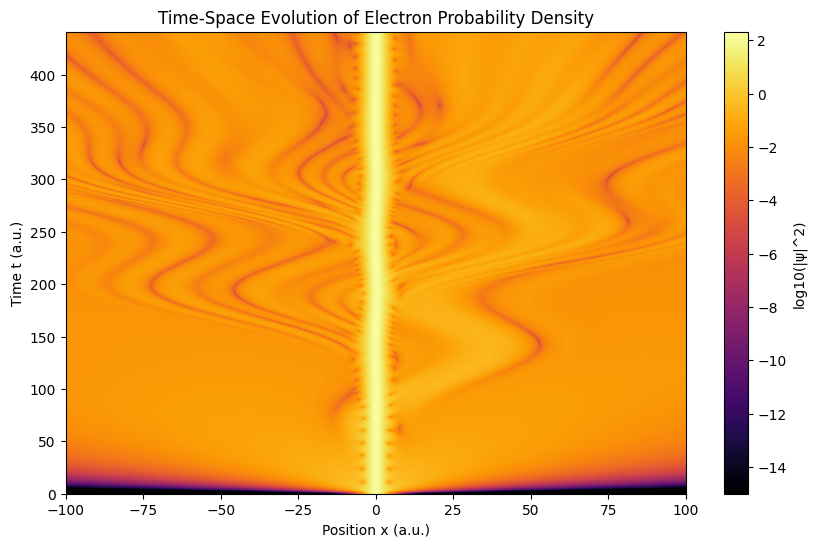

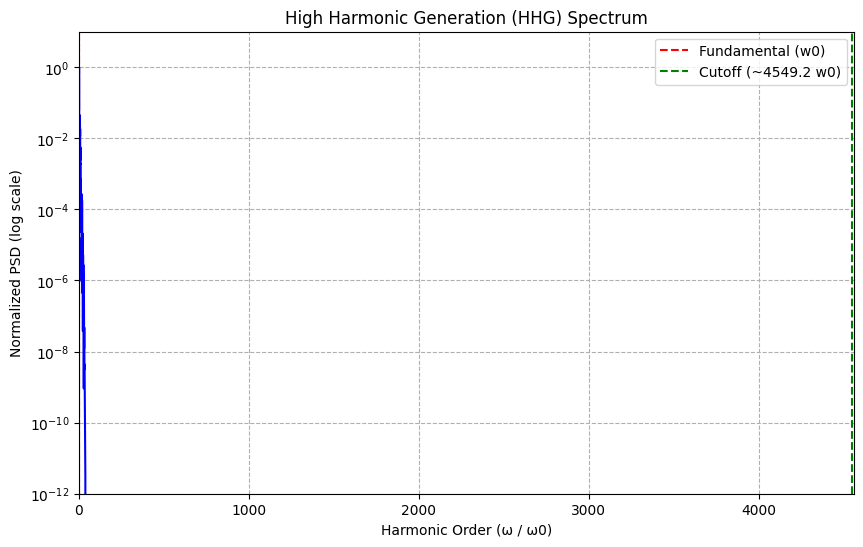

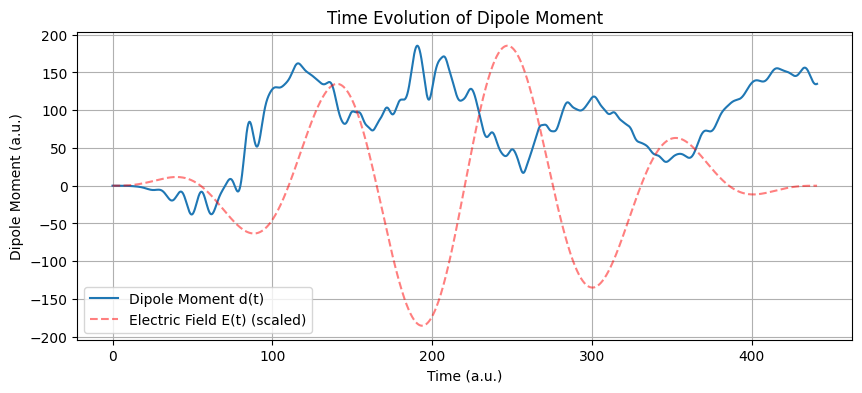

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq, fftshift

# ==========================================
# 1. 시뮬레이션 파라미터 설정 (Atomic Units)
# ==========================================
# 공간 격자 설정
L = 400.0          # 전체 공간 크기 (a.u.) - 전자가 충분히 움직일 공간 확보
N = 2048*2         # 격자점 개수 (FFT 효율을 위해 2의 거듭제곱 권장)
x = np.linspace(-L/2, L/2, N)
dx = x[1] - x[0]

# 운동량 공간 격자 설정 (FFT용)
k = fftfreq(N, d=dx) * 2 * np.pi
k_sq = k**2

# 시간 설정
dt = 0.05          # 시간 간격 (a.u.) - 충분히 작아야 함
T_pulse = 4 * 2 * np.pi / 0.057 # 약 4 optical cycles
Nt = int(T_pulse / dt)
t_axis = np.linspace(0, T_pulse, Nt)

# 물리 파라미터 설정
soft_core_a = 1.0  # Soft-core 파라미터
omega_0 = 0.057    # 레이저 주파수 (800nm Ti:Sapphire 파장 대응)
E_0 = 0.06         # 레이저 피크 전기장 강도 (약 1.2 x 10^14 W/cm^2)

print(f"Simulation Parameters:")
print(f"Grid Size: {L} a.u., Points: {N}, dx: {dx:.4f}")
print(f"Time Steps: {Nt}, dt: {dt:.4f}, Total Time: {T_pulse:.2f} a.u.")
print(f"Laser Intensity E0: {E_0}, Frequency w0: {omega_0}")
print("-" * 30)


# ==========================================
# 2. 포텐셜 및 연산자 정의 함수
# ==========================================
def get_V_atom(x, a):
    """Soft-core Coulomb Potential"""
    return -1.0 / np.sqrt(x**2 + a**2)

def get_E_field(t, E0, w0, T_pulse):
    """전기장 E(t) 정의: sin^2 포락선을 가진 펄스"""
    if 0 <= t <= T_pulse:
        envelope = np.sin(np.pi * t / T_pulse)**2
        return E0 * envelope * np.sin(w0 * t)
    else:
        return 0.0

def get_CAP(x, L, width_ratio=0.1, strength=1.0):
    """Complex Absorbing Potential (CAP)
    격자 양 끝 10% 영역에서 작동하는 sin^2 형태의 흡수 포텐셜
    """
    mask = np.zeros_like(x)
    abs_x = np.abs(x)
    boundary_start = L/2 * (1 - width_ratio)
    
    indices = abs_x > boundary_start
    mask[indices] = strength * np.sin(np.pi/2 * (abs_x[indices] - boundary_start) / (L/2 - boundary_start))**2
    return mask

# 정적 포텐셜 계산
V_atom = get_V_atom(x, soft_core_a)
V_cap = get_CAP(x, L)

# SSFM 연산자 준비
# 운동 에너지 전파자 (k-space에서 적용)
T_prop = np.exp(-1j * k_sq / 2 * dt)

# ==========================================
# 3. 초기 상태 (Ground State) 찾기 - 허수 시간 전파 (ITE)
# ==========================================
print("Calculating Ground State via Imaginary Time Evolution...")
psi = np.exp(-x**2 / 2) # 초기 가우시안 추정
psi = psi / np.linalg.norm(psi) * np.sqrt(N) # 정규화

# ITE용 전파자 (dt -> -i*dtau)
dtau = 0.05
T_prop_ite = np.exp(-k_sq / 2 * dtau)
V_prop_ite = np.exp(-V_atom * dtau)

for i in range(2000): # 수렴할 때까지 반복
    # SSFM (Strang Splitting) for ITE
    psi = V_prop_ite * psi
    psi = ifft(T_prop_ite * fft(psi))
    psi = V_prop_ite * psi
    psi = psi / np.linalg.norm(psi) * np.sqrt(N) # 매 스텝 정규화 필수

E_gs = np.sum(np.conj(psi) * ifft(k_sq/2 * fft(psi)) + V_atom * np.abs(psi)**2) * dx
print(f"Ground State Energy found: {E_gs.real:.5f} a.u.")
psi_initial = psi.copy() # 바닥 상태 저장

# ==========================================
# 4. 실제 시간 전파 (Real Time Propagation) 및 데이터 수집
# ==========================================
print("Starting Real-Time Propagation with Laser Field...")
psi = psi_initial.copy()
dipole_moment = np.zeros(Nt)
wavefunction_history = np.zeros((Nt, N), dtype=np.complex128) # 시각화용 저장

# CAP Mask (매 스텝 곱해줌)
CAP_mask = np.exp(-V_cap * dt)

# 메인 루프 (SSFM)
for i, t in enumerate(t_axis):
    # 현재 시간의 레이저 포텐셜 계산
    E_now = get_E_field(t + dt/2, E_0, omega_0, T_pulse) # t+dt/2 시점 사용 (Strang splitting)
    V_laser_now = x * E_now
    V_total_half = V_atom + V_laser_now
    
    # 위치 에너지 전파자 (반 스텝)
    V_prop_half = np.exp(-1j * V_total_half * dt / 2)
    
    # --- SSFM 1단계: V 반 스텝 ---
    psi = V_prop_half * psi
    
    # --- SSFM 2단계: T 한 스텝 (FFT -> 곱셈 -> IFFT) ---
    psi = ifft(T_prop * fft(psi))
    
    # --- SSFM 3단계: V 반 스텝 ---
    psi = V_prop_half * psi
    
    # --- CAP 적용 (경계 흡수) ---
    psi = psi * CAP_mask
    
    # 데이터 수집
    # 쌍극자 모멘트 d(t) = <psi|x|psi> 계산
    dipole_moment[i] = np.real(np.sum(np.conj(psi) * x * psi) * dx)
    wavefunction_history[i, :] = psi

print("Propagation Finished.")

# ==========================================
# 5. 분석 및 시각화
# ==========================================

# --- Fig 1: 시간-공간 파동함수 전개 (히트맵) ---
plt.figure(figsize=(10, 6))
# 시각화를 위해 로그 스케일 적용 및 중앙 부분만 crop
extent = [-L/4, L/4, t_axis[0], t_axis[-1]]
crop_idx = (x > -L/4) & (x < L/4)
plt.imshow(np.log10(np.abs(wavefunction_history[:, crop_idx])**2 + 1e-15), 
           aspect='auto', origin='lower', extent=extent, cmap='inferno')
plt.colorbar(label='log10(|ψ|^2)')
plt.title('Time-Space Evolution of Electron Probability Density')
plt.xlabel('Position x (a.u.)')
plt.ylabel('Time t (a.u.)')
plt.show()

# --- Fig 2: HHG 스펙트럼 분석 ---
# 윈도우 함수 적용 (스펙트럼 누수 방지)
window = np.hanning(Nt)
dipole_windowed = (dipole_moment - np.mean(dipole_moment)) * window

# FFT 수행
spectrum = fftshift(fft(dipole_windowed))
freqs = fftshift(fftfreq(Nt, d=dt))

# 주파수를 레이저 주파수 단위로 변환 (Harmonic Order)
harmonic_order = freqs * 2 * np.pi / omega_0
psd = np.abs(spectrum)**2 # Power Spectral Density

plt.figure(figsize=(10, 6))
# 양의 주파수 영역만 플롯
mask_freq = harmonic_order > 0.1
plt.semilogy(harmonic_order[mask_freq], psd[mask_freq]/np.max(psd), 'b')

# 주요 랜드마크 표시
plt.axvline(x=1, color='r', linestyle='--', label='Fundamental (w0)')
# Cutoff 에너지 예상치 (Ip + 3.17 Up)
Ip = np.abs(E_gs.real) # 이온화 에너지
Up = E_0**2 / (4 * omega_0**2) # Ponderomotive energy
cutoff_energy = Ip + 3.17 * Up
cutoff_order = cutoff_energy / omega_0
plt.axvline(x=cutoff_order, color='g', linestyle='--', label=f'Cutoff (~{cutoff_order:.1f} w0)')

plt.title('High Harmonic Generation (HHG) Spectrum')
plt.xlabel('Harmonic Order (ω / ω0)')
plt.ylabel('Normalized PSD (log scale)')
plt.xlim(0, cutoff_order + 10)
plt.ylim(1e-12, 1e1)
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()

# --- Fig 3: 쌍극자 모멘트와 전기장 시간 변화 ---
plt.figure(figsize=(10, 4))
plt.plot(t_axis, dipole_moment, label='Dipole Moment d(t)')
# 전기장을 스케일 맞춰서 같이 보여줌
E_field_vals = np.array([get_E_field(t, E_0, omega_0, T_pulse) for t in t_axis])
plt.plot(t_axis, E_field_vals / np.max(E_field_vals) * np.max(np.abs(dipole_moment)), 
         'r--', alpha=0.5, label='Electric Field E(t) (scaled)')
plt.title('Time Evolution of Dipole Moment')
plt.xlabel('Time (a.u.)')
plt.ylabel('Dipole Moment (a.u.)')
plt.legend()
plt.grid()
plt.show()

Lattice Constant: 4.0, Potential Depth: 0.3
Electric Field Strength: 0.005
Theoretical Bloch Period: 314.16 a.u.
Starting Simulation...
Simulation Complete.


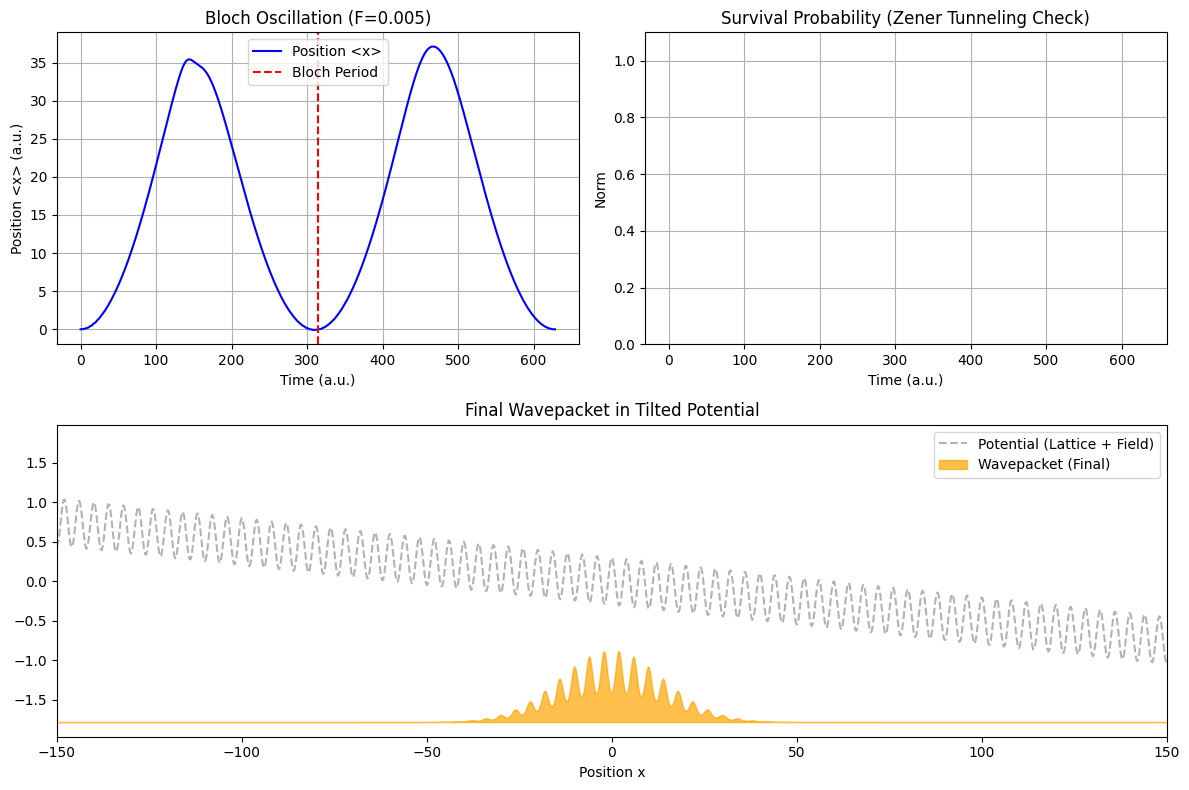

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq, fftshift

# ==========================================
# 1. 파라미터 및 격자 설정 (Atomic Units)
# ==========================================
# 공간 격자
L = 600.0          # 전체 공간 크기 (충분히 커야 함)
N = 2048           # 격자점 수
x = np.linspace(-L/2, L/2, N)
dx = x[1] - x[0]

# 운동량 격자
k = fftfreq(N, d=dx) * 2 * np.pi
k_sq = k**2

# 물리 파라미터
a = 4.0            # 격자 상수 (Lattice Constant) - 약 2 Angstrom
V0 = 0.3           # 격자 포텐셜 깊이 (Band Gap 결정)

# 실험 제어 변수 (이 값을 조절하여 현상 관찰)
# Case 1: Bloch Oscillation (약한 전기장) -> F = 0.005
# Case 2: Zener Tunneling (강한 전기장) -> F = 0.04
F_field = 0.005    # 전기장 세기 (Force)

print(f"Lattice Constant: {a}, Potential Depth: {V0}")
print(f"Electric Field Strength: {F_field}")
print(f"Theoretical Bloch Period: {2 * np.pi / (a * F_field):.2f} a.u.")

# ==========================================
# 2. 포텐셜 정의
# ==========================================
# 결정 격자 포텐셜 (Cosine)
V_lattice = V0 * np.cos(2 * np.pi * x / a)

# 외부 전기장 포텐셜 (Washboard Potential)
# 중심에서 0이 되도록 설정하여 초기 에너지를 안정화
V_external = -F_field * x 

# 경계 흡수 포텐셜 (CAP) - 터널링된 입자가 반사되지 않게 흡수
def get_CAP(x, L, width_ratio=0.1, strength=2.0):
    mask = np.zeros_like(x)
    abs_x = np.abs(x)
    boundary_start = L/2 * (1 - width_ratio)
    indices = abs_x > boundary_start
    mask[indices] = strength * ((abs_x[indices] - boundary_start) / (L/2 * width_ratio))**2
    return mask

V_cap = get_CAP(x, L)
V_total_real = V_lattice + V_external

# ==========================================
# 3. 초기 상태 설정 (Initial Wavepacket)
# ==========================================
# k-space에서 좁은 가우시안 -> Real-space에서 넓은 가우시안
# 전자가 특정 밴드(k=0)에 잘 정의되어야 하므로 넓게 퍼져야 함
sigma_x = 20.0 
psi = np.exp(-x**2 / (2 * sigma_x**2))
psi = psi / np.linalg.norm(psi) * np.sqrt(N) # 정규화

# 운동량 공간 분포 확인용 함수
def get_k_space_density(psi):
    psi_k = fftshift(fft(psi))
    return np.abs(psi_k)**2

# ==========================================
# 4. 시간 전파 (Time Evolution via SSFM)
# ==========================================
dt = 0.1
T_max = 2 * (2 * np.pi / (a * F_field)) # 블로흐 주기의 2배만큼 실행
Nt = int(T_max / dt)
t_axis = np.linspace(0, T_max, Nt)

# SSFM 연산자
T_prop = np.exp(-1j * k_sq / 2 * dt) # 운동에너지
# 위치에너지 (격자 + 전기장 + 흡수)
V_prop = np.exp(-1j * (V_total_real - 1j * V_cap) * dt) 

# 데이터 저장소
pos_expectation = []
k_expectation = []
norm_history = []

print("Starting Simulation...")
for t in t_axis:
    # 1. Potential Step (Full step approach for simplicity or Split half)
    # 여기서는 간단히 Lie-Trotter (V -> T) 사용해도 충분함. 
    # 정밀도를 위해 V_half -> T -> V_half (Strang) 사용
    psi = np.exp(-1j * (V_total_real - 1j * V_cap) * dt / 2) * psi
    psi = ifft(T_prop * fft(psi))
    psi = np.exp(-1j * (V_total_real - 1j * V_cap) * dt / 2) * psi
    
    # Observables 계산
    prob = np.abs(psi)**2
    current_norm = np.sum(prob) * dx # Zener Tunneling 발생 시 Norm 감소 (CAP에 흡수됨)
    norm_history.append(current_norm)
    
    # 위치 기댓값 <x>
    avg_x = np.sum(np.conj(psi) * x * psi).real * dx / current_norm
    pos_expectation.append(avg_x)
    
    # 운동량 기댓값 <k>
    # (주의: 주기적 격자에서는 k가 BZ 밖으로 나가면 fold되지만, FFT상의 k는 계속 커질 수 있음)
    # 여기서는 단순 평균보다는 파동함수의 중심 이동을 보는 것이 좋음.

print("Simulation Complete.")

# ==========================================
# 5. 결과 시각화
# ==========================================
plt.figure(figsize=(12, 8))

# Subplot 1: 위치 기댓값의 시간 변화 (블로흐 진동 확인)
plt.subplot(2, 2, 1)
plt.plot(t_axis, pos_expectation, 'b-', label='Position <x>')
plt.xlabel('Time (a.u.)')
plt.ylabel('Position <x> (a.u.)')
plt.title(f'Bloch Oscillation (F={F_field})')
plt.grid(True)

# 이론적 주기 표시
T_bloch = 2 * np.pi / (a * F_field)
plt.axvline(x=T_bloch, color='r', linestyle='--', label='Bloch Period')
plt.legend()

# Subplot 2: Norm 변화 (제너 터널링 확인)
plt.subplot(2, 2, 2)
plt.plot(t_axis, norm_history, 'g-', label='Norm (Probability)')
plt.xlabel('Time (a.u.)')
plt.ylabel('Norm')
plt.title('Survival Probability (Zener Tunneling Check)')
plt.ylim(0, 1.1)
plt.grid(True)

# Subplot 3: 포텐셜과 파동함수 스냅샷 (마지막 상태)
plt.subplot(2, 1, 2)
# 포텐셜 그리기 (스케일 조정)
plt.plot(x, V_total_real, 'k--', alpha=0.3, label='Potential (Lattice + Field)')
# 파동함수 그리기
scale_factor = np.max(np.abs(V_total_real)) / np.max(np.abs(psi)**2) * 0.5
plt.fill_between(x, np.abs(psi)**2 * scale_factor + np.min(V_total_real), 
                 np.min(V_total_real), color='orange', alpha=0.7, label='Wavepacket (Final)')

plt.xlim(-150, 150) # 중심부 확대
plt.title('Final Wavepacket in Tilted Potential')
plt.xlabel('Position x')
plt.legend()

plt.tight_layout()
plt.show()

# k-space 에서 시간에 따라 wavepacket이 어떻게 변하는지

/var/folders/x1/k24pyyhs04bb7784s3d75spr0000gn/T/ipykernel_16364/3636675240.py:92: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  current_psi = spsolve(A_mat, rhs)


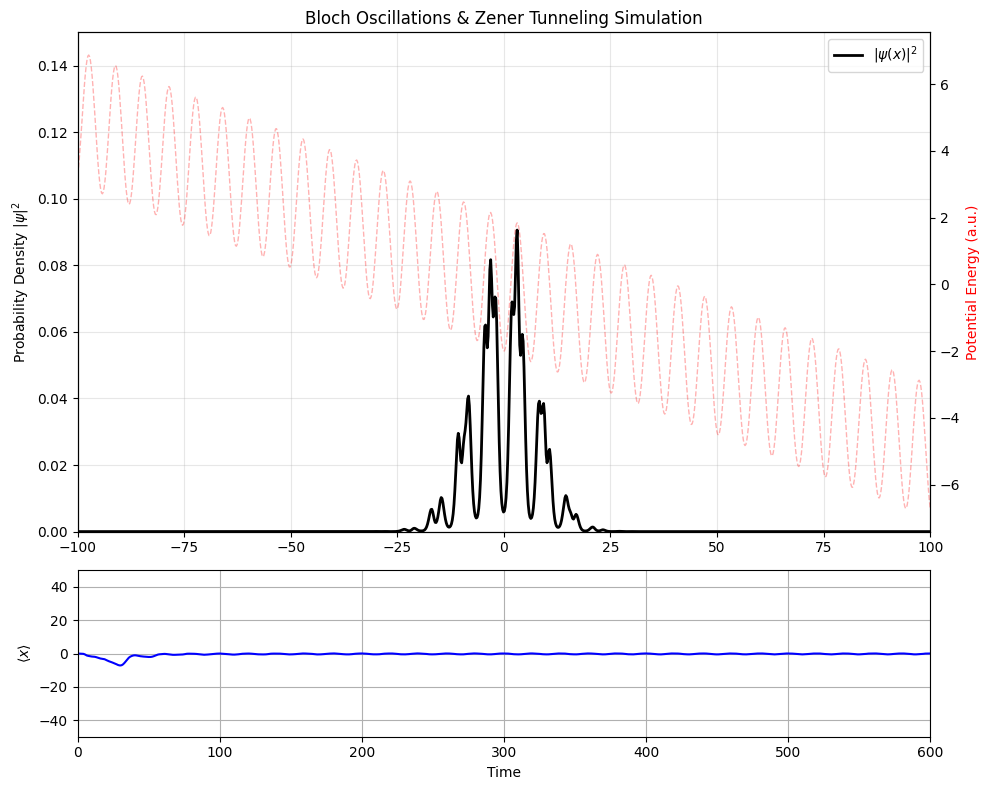

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def simulate_bloch_zener():
    hbar = 1.0
    m = 1.0
    
    N = 1000
    L = 200.0
    dx = L / N
    x = np.linspace(-L/2, L/2, N)
    
    dt = 0.05
    t_max = 600
    steps = int(t_max / dt)
    
    a = 2.0 * np.pi
    V0 = 2.0
    F = 0.05
    
    k0 = 0.0
    sigma = 10.0
    x0 = 0.0
    
    psi = np.exp(-((x - x0)**2) / (2 * sigma**2)) * np.exp(1j * k0 * x)
    psi = psi / np.sqrt(np.sum(np.abs(psi)**2) * dx)
    
    V_lattice = -V0 * np.cos(2 * np.pi * x / a)
    V_field = -F * x
    
    edge_width = L * 0.1
    absorb_mask = np.where(np.abs(x) > (L/2 - edge_width), 
                           np.abs(x) - (L/2 - edge_width), 0)
    V_imag = -1.0j * 5.0 * (absorb_mask / edge_width)**2
    
    V_total = V_lattice + V_field + V_imag
    
    diag_main = 2.0 * np.ones(N)
    diag_off = -1.0 * np.ones(N-1)
    
    T_mat = (-hbar**2 / (2 * m * dx**2)) * diags([diag_off, diag_main, diag_off], [-1, 0, 1], shape=(N, N))
    V_mat = diags([V_total], [0], shape=(N, N))
    H = T_mat + V_mat
    
    I = diags([np.ones(N)], [0], shape=(N, N))
    
    A_mat = I + (1j * dt / (2 * hbar)) * H
    B_mat = I - (1j * dt / (2 * hbar)) * H
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[3, 1])
    
    line_prob, = ax1.plot([], [], 'k-', lw=2, label=r'$|\psi(x)|^2$')
    ax1.set_xlim(-L/2, L/2)
    ax1.set_ylim(0, 0.15)
    ax1.set_ylabel(r'Probability Density $|\psi|^2$')
    ax1.set_title('Bloch Oscillations & Zener Tunneling Simulation')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    ax1_twin = ax1.twinx()
    line_pot, = ax1_twin.plot(x, np.real(V_total), 'r--', alpha=0.3, lw=1, label=r'$V(x)$')
    ax1_twin.set_ylabel('Potential Energy (a.u.)', color='r')
    
    line_expect, = ax2.plot([], [], 'b-', lw=1.5)
    ax2.set_xlim(0, t_max)
    ax2.set_ylim(-L/4, L/4)
    ax2.set_xlabel('Time')
    ax2.set_ylabel(r'$\langle x \rangle$')
    ax2.grid(True)
    
    time_data = []
    pos_data = []
    
    plot_skip = 10
    
    def init():
        line_prob.set_data([], [])
        line_pot.set_data(x, np.real(V_total))
        line_expect.set_data([], [])
        return line_prob, line_pot, line_expect
    
    current_psi = psi
    
    def animate(i):
        nonlocal current_psi
        
        for _ in range(plot_skip):
            rhs = B_mat.dot(current_psi)
            current_psi = spsolve(A_mat, rhs)
        
        prob_density = np.abs(current_psi)**2
        
        expectation_x = np.sum(x * prob_density) * dx
        current_time = i * dt * plot_skip
        
        time_data.append(current_time)
        pos_data.append(expectation_x)
        
        line_prob.set_data(x, prob_density)
        line_expect.set_data(time_data, pos_data)
        
        return line_prob, line_pot, line_expect
    
    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=int(steps/plot_skip), blit=True, interval=20)
    # ani.save('bloch_zener_animation.mp4', writer='ffmpeg', dpi=300)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    simulate_bloch_zener()

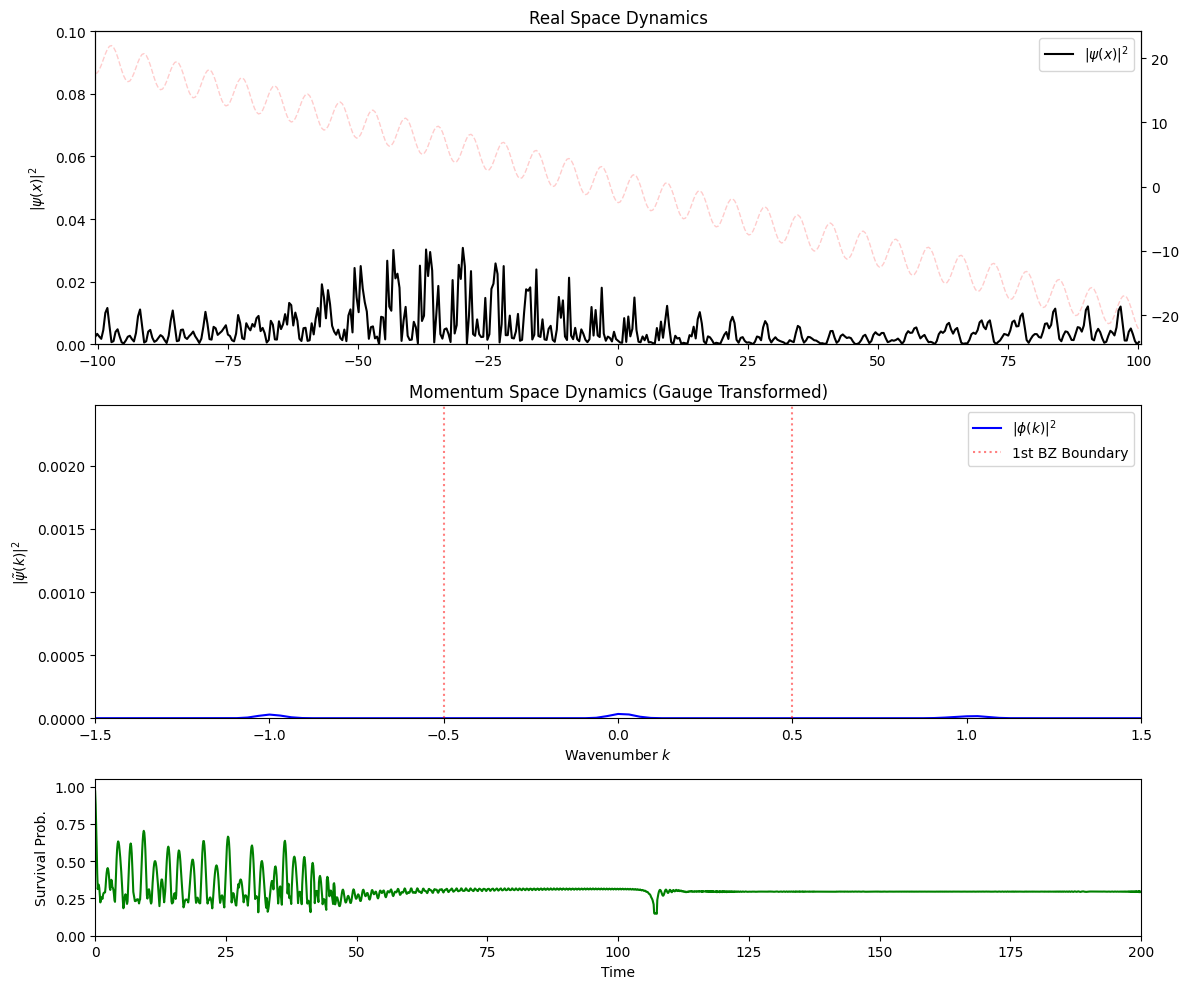

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numpy.fft import fft, ifft, fftshift, fftfreq

def run_ssfm_simulation():
    hbar = 1.0
    m = 1.0
    
    N = 512
    a_lattice = 2.0 * np.pi 
    num_cells = 32
    L = num_cells * a_lattice
    dx = L / N
    x = np.arange(-L/2, L/2, dx)
    
    dk = 2 * np.pi / L
    k = 2 * np.pi * fftfreq(N, d=dx)
    k_sorted = fftshift(k)
    
    dt = 0.02
    t_max = 200
    steps = int(t_max / dt)
    
    V0 = 2.5
    F = 0.2
    
    sigma = 3.0 * a_lattice
    k0 = 0.0
    psi = np.exp(-(x**2)/(2*sigma**2)) * np.exp(1j * k0 * x)
    psi = psi / np.sqrt(np.sum(np.abs(psi)**2) * dx)
    
    V_lat = -V0 * np.cos(2 * np.pi * x / a_lattice)
    
    exp_V = np.exp(-1j * V_lat * dt / (2 * hbar))
    
    psi_k = fft(psi)
    
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(3, 1, height_ratios=[2, 2, 1])
    
    ax_real = fig.add_subplot(gs[0])
    ax_k = fig.add_subplot(gs[1])
    ax_prob = fig.add_subplot(gs[2])
    
    line_real, = ax_real.plot([], [], 'k-', lw=1.5, label=r'$|\psi(x)|^2$')
    ax_real_twin = ax_real.twinx()
    ax_real_twin.plot(x, V_lat - F*x, 'r--', alpha=0.2, lw=1)
    
    line_k, = ax_k.plot([], [], 'b-', lw=1.5, label=r'$|\phi(k)|^2$')
    ax_k.axvline(np.pi/a_lattice, color='r', ls=':', alpha=0.5, label='1st BZ Boundary')
    ax_k.axvline(-np.pi/a_lattice, color='r', ls=':', alpha=0.5)
    
    line_surv, = ax_prob.plot([], [], 'g-', lw=1.5, label='Ground Band Probability')
    
    ax_real.set_xlim(-L/2, L/2)
    ax_real.set_ylim(0, 0.1)
    ax_real.set_ylabel(r'$|\psi(x)|^2$')
    ax_real.set_title('Real Space Dynamics')
    ax_real.legend(loc='upper right')
    
    k_lim = 3 * (np.pi/a_lattice)
    ax_k.set_xlim(-k_lim, k_lim)
    ax_k.set_ylim(0, np.max(np.abs(psi_k)**2) / N**2 * 1.5)
    ax_k.set_xlabel(r'Wavenumber $k$')
    ax_k.set_ylabel(r'$|\tilde{\psi}(k)|^2$')
    ax_k.set_title('Momentum Space Dynamics (Gauge Transformed)')
    ax_k.legend(loc='upper right')
    
    ax_prob.set_xlim(0, t_max)
    ax_prob.set_ylim(0, 1.05)
    ax_prob.set_xlabel('Time')
    ax_prob.set_ylabel('Survival Prob.')
    
    current_psi = psi
    time_points = []
    survival_probs = []
    
    plot_skip = 5
    
    bz_boundary = np.pi / a_lattice
    
    def kinetic_propagator(t_val, dt_val):
        k_shift = F * t_val / hbar
        return np.exp(-1j * (hbar**2 * (k + k_shift)**2 / (2*m)) * dt_val / hbar)
    
    def init():
        line_real.set_data([], [])
        line_k.set_data([], [])
        line_surv.set_data([], [])
        return line_real, line_k, line_surv
    
    def animate(i):
        nonlocal current_psi
        
        t_current = i * dt * plot_skip
        
        for step in range(plot_skip):
            t = t_current + step * dt
            
            current_psi = current_psi * exp_V
            
            psi_k_temp = fft(current_psi)
            psi_k_temp = psi_k_temp * kinetic_propagator(t + dt/2, dt)
            current_psi = ifft(psi_k_temp)
            
            current_psi = current_psi * exp_V
            
        prob_real = np.abs(current_psi)**2
        
        psi_k_display = fftshift(fft(current_psi)) / N
        prob_k = np.abs(psi_k_display)**2
        
        # Calculate survival probability in 1st BZ (approximate)
        # Shift k by Ft to look at the lab frame momentum distribution
        k_lab = k_sorted + (F * (t_current + dt*plot_skip) / hbar)
        # Map k_lab back to range for indexing or simple integration check
        # Here we just check the norm within the first BZ range in the shifted frame
        # For visualization simplicity, we integrate power in the central peak region
        
        # A rigorous survival prob requires projecting onto Wannier functions.
        # Instead, we use a heuristic: fraction of norm remaining within [-pi/a, pi/a] 
        # relative to the moving center of the packet in k-space.
        
        center_index = np.argmax(prob_k)
        dk_idx = int((np.pi/a_lattice) / dk)
        lower = max(0, center_index - dk_idx)
        upper = min(N, center_index + dk_idx)
        surv = np.sum(prob_k[lower:upper]) / np.sum(prob_k)
        
        time_points.append(t_current)
        survival_probs.append(surv)
        
        line_real.set_data(x, prob_real)
        line_k.set_data(k_sorted, prob_k)
        line_surv.set_data(time_points, survival_probs)
        
        return line_real, line_k, line_surv
        
    ani = animation.FuncAnimation(fig, animate, init_func=init, 
                                  frames=int(steps/plot_skip), interval=20, blit=True)
    ani.save('ssfm_animation.mp4', writer='ffmpeg', dpi=300)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_ssfm_simulation()